<div dir="rtl">
    
# المعالجة المسبقة لبيانات WaPOR باستخدام بيثون

</div>
<div dir="rtl">
يحتوي هذا الدفتر على خطوات للمعالجة المسبقة لبيانات WaPOR
</div>

<div dir="rtl">

- [1. قراءة وكتابة البيانات النقطية](#1.-Read-and-write-raster-data)
- [2. تجميع البيانات في فترة](#2.-Aggregate-data-in-a-period)
- [3. التفاف البيانات النقطية](#3.-Warp-raster-data)
- [4. عمل مقطع إلى ملف الشكل cutline](#4.-Clip-to-Shapefile-cutline)

</div>

<div dir="rtl">
في كل خطوة، ستجد أمثلة على أكواد وتمارين لتطبيق المثالفي كل خطوة، ستجد أمثلة على أكواد وتمارين لتطبيق المثال
</div>
<div dir="rtl">
أولاً، قم باستيراد مكتبات / حزم بحيث يمكن استخدام الوظائف من هذه المكتبات. 
</div>

In [1]:
import os
import sys
import shapefile
import glob
import gdal
import osgeo
import osr
import ogr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
folder=r"..\..\modules"
sys.path.append(folder) #أضف مجلدًا بالوحدات المحلية إلى مسارات النظام
import WaPOR #استيراد وحدة محلية "WaPOR"
WaPOR.API.getCatalog()

Loading WaPOR catalog...
Loading WaPOR catalog...Done


code                                            caption  \
0             L1_GBWP_A                   Gross Biomass Water Productivity   
1             L1_NBWP_A                     Net Biomass Water Productivity   
2             L1_AETI_A  Actual EvapoTranspiration and Interception (An...   
3             L1_AETI_M  Actual EvapoTranspiration and Interception (Mo...   
4             L1_AETI_D  Actual EvapoTranspiration and Interception (De...   
..                  ...                                                ...   
193        L2_BAS_PHE_S             Phenology (Seasonal, clipped by basin)   
194  L2_BAS_QUAL_NDVI_D  Quality of Normalized Difference Vegetation In...   
195  L2_CTY_QUAL_NDVI_D  Quality of Normalized Difference Vegetation In...   
196   L2_BAS_QUAL_LST_D  Quality Land Surface Temperature (Dekadal, cli...   
197   L2_CTY_QUAL_LST_D  Quality Land Surface Temperature (Dekadal, cli...   

                                           description  \
0    The annual Gross Biomass Water Productivity ex...   
1    The annual Net Biomass Water Productivity expr...   
2    The actual EvapoTranspiration and Interception...   
3    The actual EvapoTranspiration and Interception...   
4    The actual EvapoTranspiration and Interception...   
..                                                 ...   
193  This is a system dataset, used to let the down...   
194  This is a system dataset, used to let the down...   
195  This is a system dataset, used to let the down...   
196  This is a system dataset, used to let the down...   
197  This is a system dataset, used to let the down...   

                                        additionalInfo  \
0    {'format': 'Raster Dataset', 'unit': 'kg/m³ is...   
1    {'format': 'Raster Dataset', 'unit': 'kg/m³ is...   
2    {'format': 'Raster Dataset', 'unit': 'mm', 'da...   
3    {'format': 'Raster Dataset', 'unit': 'mm', 'da...   
4    {'format': 'Raster Dataset', 'unit': 'mm', 'da...   
..                                                 ...   
193                                                NaN   
194                                                NaN   
195                                                NaN   
196                                                NaN   
197                                                NaN   

                                                  tags workspaceCode dataType  \
0    [{'name': 'L1', 'index': 1, 'context': 'LEVELS...       WAPOR_2   RASTER   
1    [{'name': 'L1', 'index': 2, 'context': 'LEVELS...       WAPOR_2   RASTER   
2    [{'name': 'L1', 'index': 3, 'context': 'LEVELS...       WAPOR_2   RASTER   
3    [{'name': 'L1', 'index': 4, 'context': 'LEVELS...       WAPOR_2   RASTER   
4    [{'name': 'L1', 'index': 5, 'context': 'LEVELS...       WAPOR_2   RASTER   
..                                                 ...           ...      ...   
193                                                NaN       WAPOR_2   RASTER   
194                                                NaN       WAPOR_2   RASTER   
195                                                NaN       WAPOR_2   RASTER   
196                                                NaN       WAPOR_2   RASTER   
197                                                NaN       WAPOR_2   RASTER   

     index                                          operation  hidden  \
0      101  {'pixelTimeSeries': True, 'areaStatsTimeSeries...   False   
1      102  {'pixelTimeSeries': True, 'areaStatsTimeSeries...   False   
2      103  {'pixelTimeSeries': True, 'areaStatsTimeSeries...   False   
3      104  {'pixelTimeSeries': True, 'areaStatsTimeSeries...   False   
4      105  {'pixelTimeSeries': True, 'areaStatsTimeSeries...   False   
..     ...                                                ...     ...   
193   4151  {'pixelTimeSeries': False, 'areaStatsTimeSerie...    True   
194   4161  {'pixelTimeSeries': False, 'areaStatsTimeSerie...    True   
195   4162  {'pixelTimeSeries': False, 'areaStatsTimeSerie

## 1. Read and write raster data
<div dir="rtl"> 
    
## 1. قراءة وكتابة البيانات النقطية

</div>
<div dir="rtl">
    
### مثال
    
</div>

<div dir="rtl">     
لاقتصاص تعيين الخريطة النقطية إلى حد ما ، يلزم وجود ملف شكل أو إحداثيات المدى. على سبيل المثال ، تم إعداد ملف أشكالمن أجل العمل مع البيانات النقطية في Python ، سنحتاج إلى فتح مجموعة البيانات النقطية كمصفوفة عددية وإجراء العمليات الحسابية باستخدام هذه المصفوفة. تحتوي الحزمة * gdal * على وظائف للعمل مع مجموعة الخرائط النقطية التي يمكن استخدامها للقيام بهذه المهمة. فيما يلي خطوات الحصول على هذه المعلومات من ملف GeoTIFF. في هذا المثال ، سنستخدم مجموعات البيانات النقطية للنتح الفعلي والاعتراض (AETI) من المستوى 1 الشهري التي تم تنزيلها في تمرين [دفتر الملاحظات] السابق.
</div>
<br>
<div dir='rtl'>
أولاً ، لفتح ملف نقطي ، سنحتاج إلى المسار إلى هذا الملف. في خلية الكود أدناه ، تحصل الشفرة على قائمة الملفات النقطية (بتنسيق GeoTIFF) في مجلد إدخال ثم اطبع مسار الملف الأول. 
</div>

[دفتر الملاحظات](1_Bulk_download_WaPOR_data.ipynb)

In [2]:
input_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M' #حدد ملف الإدخال
input_fhs=sorted(glob.glob(input_folder+'\*.tif')) #احصل على قائمة بملفات GeoTIFF النقطية في ملف الإدخال

in_fh=input_fhs[0] #احصل على مسار الملف الأول
print(in_fh)

.\data\WAPOR.v2_monthly_L1_AETI_M\L1_AETI_0901M.tif


<div dir="rtl">
يحتوي الملف النقطي على العديد من الخصائص بما في ذلك الحجم وقيمة nodata والتحويل والمرجع المكاني والإسقاط وما إلى ذلك. يتم تخزين هذه المعلومات في مجموعة البيانات ويمكن قراءتها باستخدام حزمة gdal. يوجد أدناه الكود للحصول على هذه المعلومات من ملف GeoTIFF in_fh.
</div>

In [3]:
DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly) #فتح خطوط المسح في مسار in_fh

Type = DataSet.GetDriver().ShortName #GDAL driver
bandnumber=1 
Subdataset = DataSet.GetRasterBand(bandnumber) # احصل على مجموعة البيانات الفرعية للنطاق 1
NDV = Subdataset.GetNoDataValue() # لا توجد قيمة بيانات
xsize = DataSet.RasterXSize # عدد الأعمدة في خطوط المسح
ysize = DataSet.RasterYSize # عدد الصفوف في خطوط المسح
GeoT = DataSet.GetGeoTransform() # التحويل الجغرافي (تنسيق وحدات بكسل الزاوية)
Projection = osr.SpatialReference() # نظام الإسناد المكاني للخطوط النقطية
Projection.ImportFromWkt(DataSet.GetProjectionRef())
driver = gdal.GetDriverByName(Type)

print('driver: {0} \nNodata Value: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
    driver, NDV, xsize, ysize, GeoT, Projection)) #print metadata

driver: <osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x000001C9F13A2090> > 
Nodata Value: -9999.0
xsize: 2851
ysize: 2461
GeoT: (37.45758935778001, 0.0022321428599999995, 0.0, 12.888392836720001, 0.0, -0.0022321428599999995)
Projection: GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


<div dir="rtl">
    يمكن قراءة البيانات الموجودة في مجموعة بيانات gdal باستخدام وظيفة ReadAsArray. على سبيل المثال ، يتم استخدام الكود أدناه لقراءة مجموعة بيانات GeoTIFF المفتوحة كمصفوفة عددية. يمكنك رسم البيانات في هذه المصفوفة باستخدام الوظيفة في مكتبة matplotlib. انظر إلى رمز المثال ومخطط الإخراج أدناه. لاحظ مكان حدوث ارتفاع مستوى البخرنتح.نظرًا لأن هذه هي البيانات التي يعرضها AETI شهريًا ، ستكون وحدة شريط الألوان مم في الشهر
</div>

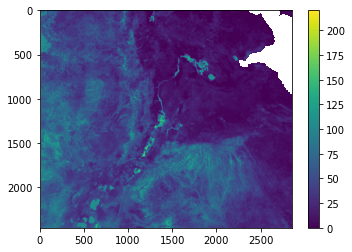

In [4]:
Array = Subdataset.ReadAsArray().astype(np.float32) # قراءة مجموعة البيانات الفرعية كمصفوفة رقمية
Array[Array == NDV] = np.nan # استبدل لا توجد قيمة بيانات بقيمة NAN

plt.imshow(Array)# مخطط مجموعة كصورة

plt.colorbar()
plt.show()

<div dir="rtl">
   بمجرد فتحها كمصفوفة عددية NumPy ، يمكن استخدام مجموعة البيانات النقطية في حساب النقاط من خلال تطبيق العمليات الحسابية مثل الجمع (+) والطرح (-) والضرب (*) والقسمة (/). على سبيل المثال ، يحسب الكود أدناه NewArray بقسمة Array على 30 (متوسط عدد الأيام في الشهر). ثم NewArray هو متوسط AETI اليومي (مم / يوم).
    </div>

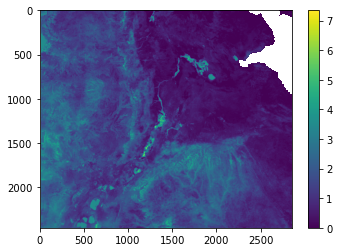

In [5]:
NewArray=Array/30
plt.imshow(NewArray)
plt.colorbar()
plt.show()

<div dir="rtl">
    يمكننا حفظ NewArray هذا كملف نقطي جديد. لحفظ النتيجة كملف صورة نقطية (GeoTIFF) ، نحتاج إلى معرفة خصائص الملف النقطي الأصلي (برنامج التشغيل ، لا توجد قيمة بيانات ، الحجم ، النطاق ، الإسقاط). يوجد أدناه مثال على حفظ المصفوفة أعلاه كملف نقطي جديد. أولاً ، يتم تحديد اسم ملف الإخراج ويتم إنشاء مجلد الإخراج إذا لم يكن موجودًا.
    </div>

In [6]:
output_folder=r'.\data\daily_average_L1_AETI_M'
if not os.path.exists(output_folder): # تحقق مما إذا كان output_folder موجودًا
    os.makedirs(output_folder) # إذا لم تقم بإنشاء ملف output_folder

filename=os.path.basename(in_fh) #احصل على اسم ملف الإدخال
out_fh=os.path.join(output_folder,filename) #يتم تحديد مسار ملف الإخراج
print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif


<div dir="rtl">
ثم يتم حفظ قيمة NewArray كـ out_fh في مجلد الإخراج (data/daily_average_L1_AETI_M) باستخدام الرموز أدناه    
</div>

[مجلد الإخراج](data/daily_average_L1_AETI_M)

In [7]:
datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
"int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
"Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    
driver, NDV, xsize, ysize, GeoT, Projection
DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes['float32']) #create dataset from driver
DataSet.GetRasterBand(1).SetNoDataValue(NDV) #set Nodata value of the new dataset
DataSet.SetGeoTransform(GeoT) #set Geotransformation
DataSet.SetProjection(Projection.ExportToWkt()) 
DataSet.GetRasterBand(1).WriteArray(NewArray) #write the CorrectedArray values to the new dataset
print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif


<div dir="rtl">

###  1 تمرين    
    
</div>

<div dir="rtl">يمكنك إنشاء وظائفك الخاصة لقراءة البيانات الوصفية ، وفتح ملف نقطي كمصفوفة ، وكتابة مصفوفة NumPy كملف نقطي. يتم تعريف الوظيفة في Python بواسطة * def *</div>

**def** Function(Inputs): #حدد اسم وظيفة البرمجة ومعلمات الإدخال

    Do something with Inputs #افعل شيئًا باستخدام المدخلات
    
    return Output 

<div dir="rtl">          
** تلميح **: استخدم أمثلة البرامج النصية في الأمثلة أعلاه. للتحقق مرة أخرى من وظائفك ، يمكنك فتح الاختبار / التعيين لهذه الوحدة في دورة OCW للاطلاع على الأمثلة المكتملة. 
    </div>

In [8]:
import glob
import os
from osgeo import gdal
import numpy as np
import osr

def GetGeoInfo(fh, subdataset = 0):
    '''
    تستخرج هذه الوظيفة البيانات الوصفية من ملف GeoTIFF أو HDF4 أو netCDF.      
    ''' 
    '''
    اكتب الكود الخاص بك هنا
    ''' 
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    '''
    تقرأ هذه الوظيفة ملف GeoTIFF أو HDF4 كمصفوفة numpy.
    ''' 
    '''
    اكتب الكود الخاص بك هنا
    ''' 
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, 
                  Projection, explicit = True, compress = None):      
    '''
    تقوم هذه الوظيفة بحفظ مصفوفة numpy كملف GeoTIFF نقطي.
    ''' 
    '''
    اكتب الكود الخاص بك هنا
    ''' 

<div dir="rtl">
بعد إكمال وتحديد الوظائف المذكورة أعلاه ، يمكنك إعادة استخدامها في الكود أدناه لحساب متوسط ملفات الصور النقطية AETI اليومية من جميع الملفات النقطية في مجلد AETI الشهري. لتطبيق نفس الوظيفة على جميع ملفات الصور النقطية ، نستخدم حلقة for-loop         
</div>

**for** in_fh **in** input_fhs:

    functions
    
<div dir="rtl">
    هذا يعني أن البرنامج النصي سيتكرر عبر جميع مسارات الملفات في ** input_fhs ** ، وهي قائمة مسارات ملفات GeoTIFF في مجلد الإدخال. في كل تكرار ، سيتم فتح الملف النقطي كمصفوفة ، تُستخدم لحساب مصفوفة جديدة ، وسيتم حفظ المصفوفة الجديدة كملف نقطي جديد في مجلد الإخراج.
</div>

In [10]:
### الحصول على البيانات النقطية الإدخال
input_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M' #مجلد الإدخال
input_fhs=sorted(glob.glob(input_folder+'\*.tif')) #احصل على قائمة بملفات .tif في مجلد الإدخال

output_folder=r'.\data\daily_average_L1_AETI_M' #مجلد الإخراج
if not os.path.exists(output_folder): #قم بإنشاء مجلد الإخراج إذا لم يكن موجودًا
    os.makedirs(output_folder)
### احصل على GeoInfo
in_fh=input_fhs[0]
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(in_fh)

### عملية حسابية
for in_fh in input_fhs:  
    ### قسّم البيانات النقطية على 30
    Array=OpenAsArray(in_fh,nan_values=True)
    NewArray=Array/30
    ### احفظ المصفوفة المحسوبة كملف نقطي
    filename=os.path.basename(in_fh)
    out_fh=os.path.join(output_folder,filename)
    CreateGeoTiff(out_fh, NewArray, driver, NDV, xsize, ysize, GeoT, Projection)
    print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0902M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0903M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0904M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0905M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0906M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0907M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0908M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0909M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0910M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0911M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0912M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1001M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1002M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1003M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1004M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1005M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1006M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1007M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1008M.tif
.\data\daily_average

## 2. Aggregate data in a period

<div dir="rtl">
    
## 2. تجميع البيانات في فترة

</div>  

<div dir="rtl">
    لتجميع البيانات في فترة ما ، يجب دمج جميع الملفات النقطية في فترة لحساب البيانات النقطية الجديدة. على سبيل المثال ، نجمع قيم البكسل في جميع مجموعات بيانات AETI النقطية في موسم واحد معًا لحساب إجمالي AETI الموسمي. في تمرين دفتر الملاحظات السابق ، قمت بتنزيل بيانات عامي 2009 و 2010. في هذا المثال ، سنقوم بحساب إجمالي AETI للموسم من يونيو 2009 إلى يونيو 2010.
</div>   

[دفتر ملاحظات سابق](1_Bulk_download_WaPOR_data.ipynb)

<div dir="rtl">
    أولاً ، سوف نحصل على قائمة الملفات النقطية المتوفرة في مجلد AETI الشهري.
</div>   

<div dir="rtl">
بعد ذلك ، سنستخدم وظيفة WaPOR.API.getAvailData لسرد جميع معرفات البيانات النقطية المتاحة من يونيو 2009 إلى يونيو 2010.
</div>    

In [12]:
start='2009-06-01'
end='2010-06-30'
time_range=f'{start},{end}'
cube_code='L1_AETI_M'
df_avail=WaPOR.API.getAvailData(cube_code, time_range)
df_avail

MONTH      raster_id                                               bbox  \
0   2009-06  L1_AETI_0906M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
1   2009-07  L1_AETI_0907M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
2   2009-08  L1_AETI_0908M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
3   2009-09  L1_AETI_0909M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
4   2009-10  L1_AETI_0910M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
5   2009-11  L1_AETI_0911M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
6   2009-12  L1_AETI_0912M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
7   2010-01  L1_AETI_1001M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
8   2010-02  L1_AETI_1002M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
9   2010-03  L1_AETI_1003M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
10  2010-04  L1_AETI_1004M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
11  2010-05  L1_AETI_1005M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   
12  2010-06  L1_AETI_1006M  [{'srid': 'EPSG:4326', 'value': [-30.0044643, ...   

                  time_code  
0   [2009-06-01,2009-07-01)  
1   [2009-07-01,2009-08-01)  
2   [2009-08-01,2009-09-01)  
3   [2009-09-01,2009-10-01)  
4   [2009-10-01,2009-11-01)  
5   [2009-11-01,2009-12-01)  
6   [2009-12-01,2010-01-01)  
7   [2010-01-01,2010-02-01)  
8   [2010-02-01,2010-03-01)  
9   [2010-03-01,2010-04-01)  
10  [2010-04-01,2010-05-01)  
11  [2010-05-01,2010-06-01)  
12  [2010-06-01,2010-07-01)

<div dir="rtl">
يتم استخدام المعرف النقطي أيضًا كاسم لملف الصورة النقطية ، لذلك يمكننا استخدام هذه القائمة لتحديد الملفات التي تنتمي إلى هذه الفترة فقط. قم بالتمرير فوق قائمة الملفات النقطية في المجلد وتحقق مما إذا كان raster_id في اسم الملف النقطي ينتمي إلى قائمة raster_id بين 6/2009 و 6/2010. إذا كان الأمر كذلك ، فسيتم إلحاق مسار الملف بقائمة جميع الملفات في الفترة.
</div>   

In [13]:
period_fhs=[]
for in_fh in input_fhs:
    #الحصول على معرف نقطي من اسم الملف
    raster_id=os.path.basename(in_fh).split('.tif')[0] #احصل على اسم الملف في المسار واستبعد الامتداد ".tif"
    #تحقق مما إذا كانت البيانات النقطية تنتمي إلى فترة
    if raster_id in list(df_avail.raster_id): #إذا كان raster_id في القائمة
        period_fhs.append(in_fh) #إلحاق مسار الملف بـ period_fhs
period_fhs

['.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0906M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0907M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0908M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0909M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0910M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0911M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0912M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1001M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1002M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1003M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1004M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1005M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1006M.tif']

<div dir="rtl">
    الآن ، يمكننا التمرير عبر هذه القائمة لجميع الملفات النقطية لتلك الفترة وجمع جميع قيم البكسل لحساب إجمالي AETI لتلك الفترة.
</div>    

In [14]:
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(period_fhs[0])
SumArray=np.zeros((ysize,xsize)) #قم بإنشاء مصفوفة صفرية بنفس حجم البيانات النقطية المدخلة
for fh in period_fhs: #كرر لجميع ملفات الصور النقطية في هذه الفترة
    Array=OpenAsArray(fh,nan_values=True)
    SumArray+=Array
out_fh=os.path.join(f'.\data\L1_AETI_{start}_{end}.tif')
CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

<div dir="rtl">
    يمكن رسم البيانات النقطية الناتجة على النحو التالي
</div>    

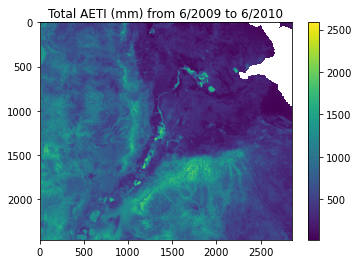

In [15]:
Array=OpenAsArray(out_fh,nan_values=True)
plt.imshow(Array)
plt.colorbar()
plt.title('Total AETI (mm) from 6/2009 to 6/2010')
plt.show()

## 3. Warp raster data

<div dir="rtl">
    
## 3. التفاف البيانات النقطية

</div>

<div dir="rtl">
تأتي البيانات المكانية بأحجام ودقة مختلفة ونظام مرجعي مكاني مختلف. على سبيل المثال ، عند فتحها كمصفوفة ، يختلف حجم خرائط الترسيب والبخرنتح الفعلي والاعتراض. يوجد أدناه حجم طبقة خطوط هطول الأمطار.
</div>    

(111, 128)


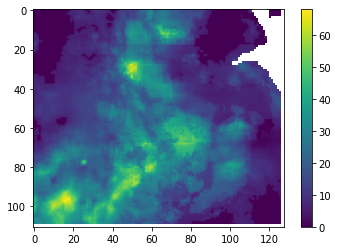

In [16]:
P_fh=r".\data\WAPOR.v2_monthly_L1_PCP_M\L1_PCP_0901M.tif"
P=OpenAsArray(P_fh,nan_values=True)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

<div dir="rtl">
    ويوجد أسفل هذه الخلية حجم طبقة AETI النقطية
</div>    

(2461, 2851)


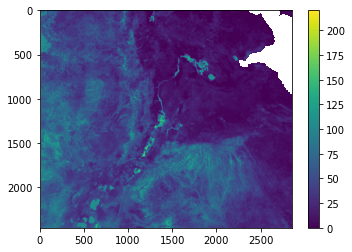

In [17]:
ET_fh=r".\data\WAPOR.v2_monthly_L1_AETI_M\L1_AETI_0901M.tif"
ET=OpenAsArray(ET_fh,nan_values=True)
print(ET.shape)
plt.imshow(ET)
plt.colorbar()
plt.show()

<div dir="rtl">
كما نرى ، فإن بيانات هطول الأمطار لها دقة أقل (0.5 درجة) ، وبالتالي حجم مصفوفة أصغر (111x128) من بيانات AETI (250 متر و 2851 × 2461). بالنسبة لهاتين النقطتين في نفس الحساب ، يجب تحويلهما إلى نفس الحجم والدقة والإسقاط. هنا ، نستخدم خريطة استخدام الأراضي كقالب لتشويه هذه البيانات في نفس النموذج.
</div>
<br>
<div dir="rtl">
يمكن القيام بذلك باستخدام دالة gdal.Warp ووظيفة فسيفساء للصورة وإعادة إسقاط وتزييف. يتم استخدام gdal.Warp لتشويه البيانات النقطية المحددة لحجم البيانات المحددة مسبقًا والمدى المكاني ، وإعادة إسقاطها إلى نظام الإسناد المكاني المحدد مسبقًا. الى gdal. قم بلف ملف نقطي لمطابقة الإسقاط والحجم والمدى مع ملف نقطي آخر ، يجب الحصول على معلومات الملف الهدف أولاً. الوظيفة التالية هي الحصول على قيمة nodata ونظام الإسناد المكاني وحجم البيانات والمدى المكاني لملف نقطي باستخدام حزمة gdal.
</div>
<br>
<div dir="rtl">
على سبيل المثال ، هنا الملف النقطي لخريطة AETI هو الملف الهدف. نريد مطابقة الإسقاط والحجم ومدى الملف المصدر، وهو هطول الأمطار، مع الملف الهدف.    
</div>

In [18]:
dst_info=gdal.Info(gdal.Open(ET_fh),format='json')
src_info=gdal.Info(gdal.Open(P_fh),format='json')

print('Target info: ',dst_info,'\n')
print('Source info: ',src_info)

Source info:  {'description': '.\\data\\WAPOR.v2_monthly_L1_PCP_M\\L1_PCP_0901M.tif', 'driverShortName': 'GTiff', 'driverLongName': 'GeoTIFF', 'files': ['.\\data\\WAPOR.v2_monthly_L1_PCP_M\\L1_PCP_0901M.tif'], 'size': [128, 111], 'coordinateSystem': {'wkt': 'GEOGCS["WGS 84",\n    DATUM["WGS_1984",\n        SPHEROID["WGS 84",6378137,298.257223563,\n            AUTHORITY["EPSG","7030"]],\n        AUTHORITY["EPSG","6326"]],\n    PRIMEM["Greenwich",0],\n    UNIT["degree",0.0174532925199433],\n    AUTHORITY["EPSG","4326"]]'}, 'geoTransform': [37.45000000000002, 0.05, 0.0, 12.9, 0.0, -0.05], 'metadata': {'': {'AREA_OR_POINT': 'Area'}, 'IMAGE_STRUCTURE': {'INTERLEAVE': 'BAND'}}, 'cornerCoordinates': {'upperLeft': [37.45, 12.9], 'lowerLeft': [37.45, 7.35], 'lowerRight': [43.85, 7.35], 'upperRight': [43.85, 12.9], 'center': [40.65, 10.125]}, 'wgs84Extent': {'type': 'Polygon', 'coordinates': [[[37.45, 12.9], [37.45, 7.35], [43.85, 7.35], [43.85, 12.9], [37.45, 12.9]]]}, 'bands': [{'band': 1, 'bl

<div dir="rtl">
بعد الحصول على src_info من المصدر ومعلومات الهدف dst_info ، يمكننا إملاء هذه المعلومات إلى gdal.Warp على النحو التالي. إذا كان gdal. انتهى من وظيفة الالتفاف بنجاح، ستقوم بإرجاع كائن osgeo.gdal.Dataset وسيتم حفظ الملف النقطي الناتج في مجلد الإخراج (data/L1_PCP_E_warped)    
</div>

[مجلد الإخراج](data/L1_PCP_M_warped)

In [19]:
source_file=P_fh
output_folder=r'.\data\L1_PCP_M_warped'
if not os.path.exists(output_folder): # إنشاء output_folder إذا لم يكن موجودًا
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) # الحصول على اسم الملف من مسار ملف المصدر
output_file=os.path.join(output_folder,filename) # إنشاء مسار ملف الإخراج

gdal.Warp(output_file,P_fh,format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              srcNodata=src_info['bands'][0]['noDataValue'],
              dstNodata=dst_info['bands'][0]['noDataValue'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001C9F1726750> >

<div dir="rtl">
    سيكون لملف البيانات النقطية لهطول الأمطار الآن نفس حجم AETI raster.
</div>    

(2461, 2851)


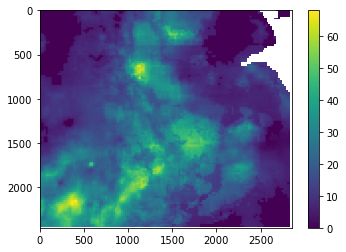

In [20]:
P=OpenAsArray(output_file,nan_values=True)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

<div dir="rtl">

### التمرين 2
    
</div>

<div dir="rtl">
    قم بإنشاء دالة لتشوه أي ملف نقطي باستخدام نقطي معينة. 
    <br/>
استخدم هذه الوظيفة لمطابقة الإسقاط والحجم ومدى جميع بيانات هطول الأمطار مع بيانات ET.<br/></div> 

<div dir="rtl">
** تلميح **: استخدم أمثلة البرامج النصية في الأمثلة أعلاه. للتحقق مرة أخرى من وظائفك ، يمكنك فتح الاختبار / التعيين لهذه الوحدة في دورة OCW للاطلاع على الأمثلة المكتملة.</div> 
  

In [21]:
def MatchProjResNDV(target_file, source_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
     تعمل هذه الوظيفة على تحويل جميع الملفات النقطية في قائمة بنفس الحجم،
    الدقة والإسقاط بملف مصدر نقطي.
    """
    '''
    اكتب رمزك هنا
    '''
    return output_files

In [23]:
input_folder=r".\data\WAPOR.v2_monthly_L1_PCP_M"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_PCP_M_warped'
MatchProjResNDV(ET_fh, input_fhs, output_folder)

array(['.\\data\\L1_PCP_M_warped\\L1_PCP_0901M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0902M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0903M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0904M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0905M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0906M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0907M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0908M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0909M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0910M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0911M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_0912M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1001M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1002M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1003M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1004M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1005M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1006M.tif',
       '.\\data\\L1_PCP_M_warped\\L1_PCP_1007M

## 4. Clip to Shapefile cutline

<div dir="rtl">

## 4. القص إلى حدود ملف الشكل

</div>

<div dir="rtl">
    عندما نحتاج إلى استبعاد وحدات البكسل خارج منطقة الاهتمام ، على سبيل المثال ، في حالة الحوض الهيدرولوجي أو كتلة الري ، يمكننا استخدام * gdal.Warp * مع خيار cutline لقص خطوط نقطية إلى حدود المضلع لملف الشكل. توضح أكواد الأمثلة أدناه كيف يتم ذلك باستخدام الخرائط النقطية لهطول الأمطار.
</div>
<br>
<div dir="rtl">
    أولاً ، نحصل على المسار إلى ملف الإدخال النقطي وننشئ مجلد إخراج
</div>    

[مجلد الإخراج](data/L1_PCP_M_clipped)

In [24]:
input_fh=r".\data\WAPOR.v2_monthly_L1_PCP_M\L1_PCP_0901M.tif" # المسار إلى البيانات النقطية المراد قصها
shp_fh=r".\data\Awash_shapefile.shp"  # المسار إلى ملف الشكل الذي يحتوي على مضلع المنطقة محل الاهتمام

output_folder=r'.\data\L1_PCP_M_clipped'# مسار لمجلد الإخراج
if not os.path.exists(output_folder): # إنشاء output_folder إذا لم يكن موجودًا
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) # الحصول على اسم الملف من مسار ملف المصدر
output_fh=os.path.join(output_folder,filename) # إنشاء مسار ملف الإخراج
print(output_fh)

.\data\L1_PCP_M_clipped\L1_PCP_0901M.tif


<div dir="rtl">
بعد تحديد الملف النقطي للإدخال والإخراج ومسارات ملف الأشكال ، يمكننا استخدام وظيفة مكتبة ogr لقراءة مجموعة بيانات الشكل ككائن gdal للحصول على اسم الطبقة. بعد ذلك ، استخدم مسار ملف الشكل والطبقة كوسائط خيارات لوظيفة gdal.Warp. تحقق من ملف الإخراج في مجلد الإخراج (data/L1_PCP_E_clipped)    
</div>

[مجلد الإخراج](data\L1_PCP_M_clipped)

In [25]:
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) # قراءة ملف الشكل كمجموعة بيانات gdal

inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)

<div dir="rtl">
يوجد أدناه قيمة إدخال البيانات النقطية قبل القطع    
</div>

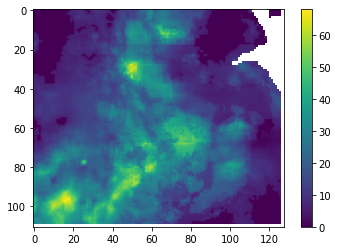

In [26]:
input_array=OpenAsArray(input_fh,nan_values=True)
plt.imshow(input_array)
plt.colorbar()
plt.show()

<div dir="rtl">
وأدناه هي قيمة الناتج النقطي بعد القطع.    
</div>

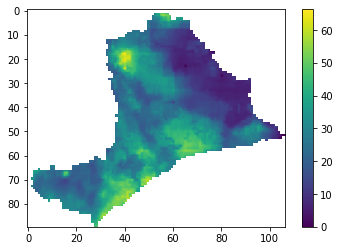

In [27]:
output_array=OpenAsArray(output_fh,nan_values=True)
plt.imshow(output_array)
plt.colorbar()
plt.show()

<div dir="rtl">
    لاحظ أن الملف النقطي الأصلي لهطول الأمطار يحتوي على دقة مكانية تبلغ 5 كيلومترات. لذلك ، عند القص إلى الخط المقطوع ، يمكننا رؤية وحدات البكسل الخشنة على الحدود. إذا كنا بحاجة إلى أن يكون الخط المختصر أكثر سلاسة ، فيمكننا استخدام ملف البيانات النقطية لهطول الأمطار الذي تم تشويهه إلى دقة مكانية أعلى (250 م) كملف إدخال. على سبيل المثال ، راجع الفرق بين الخريطة المقطوعة من دقة المسح النقطية 5 كيلومترات (أعلاه) والخريطة المقطوعة من نقطية بدقة 250 مترًا (أدناه).
</div>   

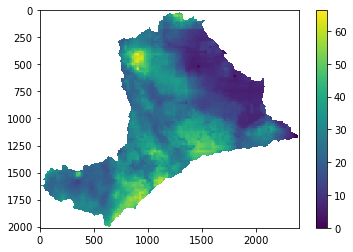

In [28]:
input_fh=r".\data\L1_PCP_M_warped\L1_PCP_0901M.tif"
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) # قراءة ملف الشكل كمجموعة بيانات gdal
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)
output_array=OpenAsArray(output_fh,nan_values=True)
plt.imshow(output_array)
plt.colorbar()
plt.show()

<div dir="rtl">

###  3 تمرين    
    
</div>

<div dir="rtl">
قم بإنشاء وظيفة CliptoShp () لقص جميع هطول الأمطار الشهرية الملتوية وجميع بيانات AETI الشهرية وبيانات LCC النقطية السنوية التي تم تنزيلها من تمرين دفتر الملاحظات السابق.
    

[دفتر الملاحظات السابق](1_Bulk_download_WaPOR_data.ipynb)<br/></div>

<div dir="rtl">
** تلميح **: استخدم أمثلة البرامج النصية في الأمثلة أعلاه. للتحقق مرة أخرى من وظائفك ، يمكنك فتح الاختبار / التعيين لهذه الوحدة في دورة OCW للاطلاع على الأمثلة المكتملة.</div>  

In [29]:
def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """
     قص خطوط المسح إلى خط الحدود لملف الشكل
    
    المعلمات
   
    
    """
    '''
   
    اكتب رمزك هنا
    '''
    return output_fhs

<div dir="rtl">
    باستخدام وظيفة ** CliptoShp ** المحددة ، يمكن قص جميع الملفات النقطية في مجلدات الإدخال إلى حد المضلع لملف الشكل. سيتم حفظ ملفات الإخراج في مجلدات الإخراج.
</div>    

In [31]:
input_folder=r".\data\L1_PCP_M_warped"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_PCP_M_clipped'
CliptoShp(input_fhs, output_folder,shp_fh)

input_folder=r".\data\WAPOR.v2_monthly_L1_AETI_M"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_AETI_M_clipped'
if not os.path.exists(output_folder): 
    os.makedirs(output_folder)
CliptoShp(input_fhs, output_folder,shp_fh)

input_folder=r".\data\WAPOR.v2_yearly_L1_LCC_A"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_LCC_A_clipped'
if not os.path.exists(output_folder): 
    os.makedirs(output_folder)
CliptoShp(input_fhs, output_folder,shp_fh)

['.\\data\\L1_LCC_A_clipped\\L1_LCC_09.tif',
 '.\\data\\L1_LCC_A_clipped\\L1_LCC_10.tif']